#Natural Lenguagge Processing
Non so molto a riguardo ora vediamo che dice

In [1]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-01-24 09:12:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-24 09:12:57 (76.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-01-24 09:13:00--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-01-24 09:13:00 (94.2 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [3]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#shuffle the dataframe i don't know why
train_df_shuffled = train_df.sample(frac=1, random_state=7)
train_df_shuffled.head()

,id,keyword,location,text,target
6106,8718,sinking,NaN,If there's a chance will get a gander of the s...,0
5025,7166,mudslide,"Chiswick, London",2 great new recipes; mudslide cake and so sorr...,0
7022,10066,typhoon,USA,#breaking #news Global precipitation measureme...,1
2331,3355,demolition,USA,EPA begins demolition of homes in toxic area #...,1
3354,4800,evacuated,"Hensley Street, Portland",KATUNews: #SR14 remains closed as brush fire b...,1


In [5]:
# Let's visualize some random training examples
sample_5 = train_df_shuffled.sample(5)
for index,row in sample_5[['text','target']].iterrows():
  text,target = row
  print(f"target {target}", "DISASTER" if(target == 1) else "NOT DISASTER")
  print(f"text: {text}")
  print("")

target 1 DISASTER
text: @jasalhad @brianboru67 @Jimskiv92 @hijinks1967 Rioting.

target 1 DISASTER
text: A look at state actions a year after Ferguson's upheaval http://t.co/vXUFtVT9AU

target 0 NOT DISASTER
text: ? The Circular Ruins - Displaced part 4 ? http://t.co/Od2ratxRqS #nowplaying

target 1 DISASTER
text: Arson suspect linked to 30 fires caught in Northern California - Los Angeles Times http://t.co/PrRB4fhXtv

target 0 NOT DISASTER
text: https://t.co/eCMUjkKqX1 @ArianaGrande @ScreamQueens 
Katherine's Death



In [6]:
from sklearn.model_selection import train_test_split
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    test_size = 0.1,
    random_state=7
)

In [7]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

#Converting text to numbers


*   Tokenization
*   Embedding




In [8]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [10]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [11]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[322,   3, 198,   5,  13, 792,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [12]:
#Embedding
tf.random.set_seed(7)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

#Modelling a text dataset


##Creating an evaluation function for our model experiments

In [13]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

##Model 0: Getting a baseline
We will use multinomial Naive Bayes model, it is not present on TF so we will use SkLearn

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [15]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 80.45%


In [16]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [17]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 80.4461942257218,
 'f1': 0.797864181349013,
 'precision': 0.8192301911628134,
 'recall': 0.8044619422572179}

##Model 1: A simple dense model

In [18]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [20]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [21]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

In [25]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions

In [26]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.26509186351706,
 'f1': 0.7901978722151148,
 'precision': 0.7937666008532149,
 'recall': 0.7926509186351706}

In [27]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 80.45, New accuracy: 79.27, Difference: -1.18
Baseline precision: 0.82, New precision: 0.79, Difference: -0.03
Baseline recall: 0.80, New recall: 0.79, Difference: -0.01
Baseline f1: 0.80, New f1: 0.79, Difference: -0.01


##Model 2: LSTM

In [28]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [29]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220124-114013
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.5110 - accuracy: 0.7408 - val_loss: 0.4586 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.3155 - accuracy: 0.8746 - val_loss: 0.4842 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2230 - accuracy: 0.9161 - val_loss: 0.5100 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1565 - accuracy: 0.9437 - val_loss: 0.5982 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1044 - accuracy: 0.9612 - val_loss: 0.6776 - val_accuracy: 0.7585


In [32]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [33]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.8530183727034,
 'f1': 0.7589648940974039,
 'precision': 0.7597765159181519,
 'recall': 0.7585301837270341}

In [34]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 80.45, New accuracy: 75.85, Difference: -4.59
Baseline precision: 0.82, New precision: 0.76, Difference: -0.06
Baseline recall: 0.80, New recall: 0.76, Difference: -0.05
Baseline f1: 0.80, New f1: 0.76, Difference: -0.04


##Model 3: GRU

In [35]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [70]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
print(x.shape)
x = layers.GRU(64)(x)
print(x.shape)

(None, 15, 128)
(None, 64)


In [36]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220124-115203
Epoch 1/5
215/215 [==============================] - 10s 33ms/step - loss: 0.5304 - accuracy: 0.7253 - val_loss: 0.4617 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3199 - accuracy: 0.8699 - val_loss: 0.4766 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.2223 - accuracy: 0.9148 - val_loss: 0.5177 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1604 - accuracy: 0.9421 - val_loss: 0.6049 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1187 - accuracy: 0.9613 - val_loss: 0.6202 - val_accuracy: 0.7533


In [38]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [39]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.32808398950131,
 'f1': 0.7540426577088458,
 'precision': 0.7562976073167142,
 'recall': 0.7532808398950132}

In [40]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 80.45, New accuracy: 75.33, Difference: -5.12
Baseline precision: 0.82, New precision: 0.76, Difference: -0.06
Baseline recall: 0.80, New recall: 0.75, Difference: -0.05
Baseline f1: 0.80, New f1: 0.75, Difference: -0.04


##Model 4: Bidirectonal RNN model

In [41]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [42]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220124-115953
Epoch 1/5
215/215 [==============================] - 13s 44ms/step - loss: 0.5080 - accuracy: 0.7485 - val_loss: 0.4510 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.3102 - accuracy: 0.8762 - val_loss: 0.4827 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.2122 - accuracy: 0.9218 - val_loss: 0.5115 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1472 - accuracy: 0.9517 - val_loss: 0.6104 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.1009 - accuracy: 0.9651 - val_loss: 0.7421 - val_accuracy: 0.7454


In [44]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [45]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.54068241469817,
 'f1': 0.7463920043975085,
 'precision': 0.750697803003051,
 'recall': 0.7454068241469817}

In [46]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 80.45, New accuracy: 74.54, Difference: -5.91
Baseline precision: 0.82, New precision: 0.75, Difference: -0.07
Baseline recall: 0.80, New recall: 0.75, Difference: -0.06
Baseline f1: 0.80, New f1: 0.75, Difference: -0.05


##Model 5: Conv1D

In [47]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)              

In [48]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220124-120401
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.5691 - accuracy: 0.7160 - val_loss: 0.4627 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3448 - accuracy: 0.8558 - val_loss: 0.4577 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2120 - accuracy: 0.9215 - val_loss: 0.5219 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1325 - accuracy: 0.9553 - val_loss: 0.5730 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0909 - accuracy: 0.9708 - val_loss: 0.6390 - val_accuracy: 0.7703


In [49]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [50]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.03412073490814,
 'f1': 0.7695499350447832,
 'precision': 0.7695374207977917,
 'recall': 0.7703412073490814}

In [51]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 80.45, New accuracy: 77.03, Difference: -3.41
Baseline precision: 0.82, New precision: 0.77, Difference: -0.05
Baseline recall: 0.80, New recall: 0.77, Difference: -0.03
Baseline f1: 0.80, New f1: 0.77, Difference: -0.03


##Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [52]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

In [53]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [54]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220124-121139
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5005 - accuracy: 0.7860 - val_loss: 0.4465 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4142 - accuracy: 0.8164 - val_loss: 0.4380 - val_accuracy: 0.8018
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3999 - accuracy: 0.8244 - val_loss: 0.4400 - val_accuracy: 0.8018
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3925 - accuracy: 0.8275 - val_loss: 0.4376 - val_accuracy: 0.8071
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3842 - accuracy: 0.8327 - val_loss: 0.4358 - val_accuracy: 0.8084


In [56]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [58]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.83989501312337,
 'f1': 0.8075056483538134,
 'precision': 0.8079901516735187,
 'recall': 0.8083989501312336}

In [59]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 80.45, New accuracy: 80.84, Difference: 0.39
Baseline precision: 0.82, New precision: 0.81, Difference: -0.01
Baseline recall: 0.80, New recall: 0.81, Difference: 0.00
Baseline f1: 0.80, New f1: 0.81, Difference: 0.01


##Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [61]:
import numpy as np
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [62]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [63]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20220124-121954
Epoch 1/5
22/22 [==============================] - 4s 51ms/step - loss: 0.6743 - accuracy: 0.6356 - val_loss: 0.6505 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6100 - accuracy: 0.8017 - val_loss: 0.5872 - val_accuracy: 0.7585
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5331 - accuracy: 0.8207 - val_loss: 0.5313 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4734 - accuracy: 0.8251 - val_loss: 0.4999 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4328 - accuracy: 0.8338 - val_loss: 0.4840 - val_accuracy: 0.7730


In [64]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

In [65]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.29658792650919,
 'f1': 0.7714846667788573,
 'precision': 0.7722968169391692,
 'recall': 0.7729658792650919}

In [66]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 80.45, New accuracy: 77.30, Difference: -3.15
Baseline precision: 0.82, New precision: 0.77, Difference: -0.05
Baseline recall: 0.80, New recall: 0.77, Difference: -0.03
Baseline f1: 0.80, New f1: 0.77, Difference: -0.03


#Comparing the performance of each of our models

In [82]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results['accuracy'] = all_model_results['accuracy']/100.0 
all_model_results

,accuracy,precision,recall,f1
baseline,0.804462,0.819230,0.804462,0.797864
simple_dense,0.792651,0.793767,0.792651,0.790198
lstm,0.758530,0.759777,0.758530,0.758965
gru,0.753281,0.756298,0.753281,0.754043
bidirectional,0.745407,0.750698,0.745407,0.746392
conv1d,0.770341,0.769537,0.770341,0.769550
tf_hub_sentence_encoder,0.808399,0.807990,0.808399,0.807506
tf_hub_10_percent_data,0.772966,0.772297,0.772966,0.771485


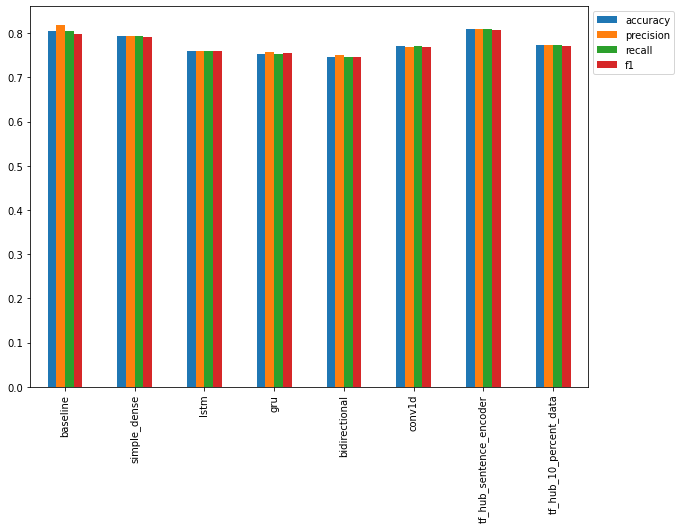

In [83]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

#Model Ensemble

In [84]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1.], dtype=float32)>

In [85]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 76.37795275590551,
 'f1': 0.7647392956477455,
 'precision': 0.7739468574477145,
 'recall': 0.7637795275590551}

In [86]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [87]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [88]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.804462,0.819230,0.804462,0.797864
simple_dense,0.792651,0.793767,0.792651,0.790198
lstm,0.758530,0.759777,0.758530,0.758965
gru,0.753281,0.756298,0.753281,0.754043
bidirectional,0.745407,0.750698,0.745407,0.746392
conv1d,0.770341,0.769537,0.770341,0.769550
tf_hub_sentence_encoder,0.808399,0.807990,0.808399,0.807506
tf_hub_10_percent_data,0.772966,0.772297,0.772966,0.771485
ensemble_results,0.763780,0.773947,0.763780,0.764739
